In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.nn import BCELoss, Linear, Module, ReLU, Sigmoid
from torch.nn.init import kaiming_uniform_, xavier_uniform_
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
################################################################################
ML_Type = 'Class'
Gene_Type = 'Common'
Feature_Size = 2100  # Feature size {50, 100, 200, 400, 600, 800, 1000}
print(ML_Type)
print(Gene_Type)
#print("Size of the Columns/Features is: %d." %(Feature_Size))
dataDir = 'E:/1st Project/'
dataDir = dataDir + str(ML_Type) + '/' + str(Gene_Type) + '/' + str(Feature_Size) + '/'
outputDir = dataDir
dataType = '';
print(dataDir)
################################################################################
indx = 1
print(indx)
prt1 = 'X_orig_'+str(indx)+'.csv'
prt2 = 'X_ko1_'+str(indx)+'.csv'; 
prt7 = 'Y_'+str(indx)+'.csv'; 
prt8 = 'Beta_'+str(indx)+'.csv';

output_path1 = dataDir + prt1
output_path2 = dataDir + prt2; 
output_path7 = dataDir + prt7; 
output_path8 = dataDir + prt8

X_orig = pd.read_csv(output_path1, header = None).values.astype(np.float32);
X_ko1 = pd.read_csv(output_path2, header = None).values.astype(np.float32);
Y = pd.read_csv(output_path7, header = None).values.astype(np.float32);
Beta = pd.read_csv(output_path8, header = None).values.astype(np.float32);

print("Size of the original feature is: %d x %d." %(X_orig.shape))
print("Size of the knockoff feature is: %d x %d." %(X_ko1.shape))
print("Size of the target is: %d x %d." %(Y.shape))
print("Size of the output weight is: %d x %d." %(Beta.shape))
Num_knock = 1;
bias = True;
num_ins = X_orig.shape[0];
num_dim = X_orig.shape[1];
num_epochs = 5;

Class
Common
E:/1st Project/Class/Common/2100/
1
Size of the original feature is: 10000 x 98.
Size of the knockoff feature is: 10000 x 98.
Size of the target is: 10000 x 1.
Size of the output weight is: 98 x 1.


In [2]:
X_all2 = np.zeros((num_ins,num_dim*2), dtype=float)
for i in range(num_dim):
    temp_o = X_orig[:,i].reshape((num_ins,1))
    temp_k = X_ko1[:,i].reshape((num_ins,1))
    X_all2[:,2*i:2*(i+1)] = np.concatenate((temp_o,temp_k), axis=1)
   

In [3]:
type(X_all2)

numpy.ndarray

In [4]:
# test_net.py
import torch
import tensorflow as tf
Y = torch.from_numpy(Y)
X_all2 = torch.from_numpy(X_all2).float()
X_all2.requires_grad=True
type(X_all2)

torch.Tensor

In [5]:
# out_channels: The size of the new dimension is called the number of output channels, or number of output feature maps
# In case of an RGB image, the size of the new dimension (aside from the width/height of the image) is 3.
#This "size of the 3rd dimension" is called the number of input channels or number of input feature maps.
#In the above image example, the number of input channels is 3, and we have a 3×3×3 kernel.

import torch.nn as nn
class LocallyConnected1d(nn.Module):
    def __init__(self, in_channels, out_channels, output_size, kernel_size, stride, bias=False):
        super(LocallyConnected1d, self).__init__()
        self.weight = nn.Parameter(
            torch.randn(1, out_channels, in_channels, output_size, kernel_size)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.randn(1, out_channels, output_size)
            )
        else:
            self.register_parameter('bias', None)
        self.kernel_size = kernel_size
        self.stride = stride
        
    def forward(self, x):
        #_, c, h = x.size()
        c, h = x.size()
#        print(c)
#        print(h)
        kh = self.kernel_size
        print(kh)
        dh = self.stride
        print(dh)
        #x = x.unfold(2, kh, dh)
        x = x.unfold(1, kh, dh)
        print(x.shape)
        # x = x.contiguous().view(*x.size()[:-2], -1)
        # Sum in in_channel and kernel_size dims
        x = x.unsqueeze(1)
        out = (x * self.weight)
        out = out.sum([2, -1])
        if self.bias is not None:
            out += self.bias
        return out

In [6]:

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)


In [7]:
num_dim

98

In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2048
hidden_size = 40
learning_rate = 0.01
kernel = stride = 2
from torch.nn import functional as F

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, num_dim, hidden_size):
        super(NeuralNet, self).__init__()      
        self.fc1 = nn.Linear(2*num_dim, hidden_size) 
        xavier_uniform_(self.fc1.weight)
        self.Act1 = torch.nn.functional.elu
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        xavier_uniform_(self.fc2.weight)
        self.Act2 = torch.nn.functional.elu
        self.fc3 = nn.Linear(hidden_size, 1)
        xavier_uniform_(self.fc3.weight)
        self.Act3 = Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.Act1(out)
        out = self.fc2(out)
        out = self.Act2(out)
        out = self.fc3(out)
        out = self.Act3(out)
        return out
        
    def compute_l1_loss(self, w):
        return torch.abs(w).sum()        
    

Model = NeuralNet(num_dim, hidden_size).to(device)

# Loss and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss() # initialize loss function
optimizer = torch.optim.Adam(Model.parameters(), lr=learning_rate)  


In [14]:
# Train the model
grad_bank = {}
avg_counter = 0
num_ins = X_all2.shape[0]
num_epochs = 120
p_norm = 1
l1_lambda = 0.001
Batch_counter = int(np.ceil(num_ins/batch_size))
total_step = Batch_counter
print(Batch_counter)
for epoch in range(num_epochs):   
    for step in range(Batch_counter):
        step1 = (step*batch_size)
        if step == (Batch_counter-1):
            step2 = num_ins
        else: 
            step2 = (step+1)*batch_size
        # Forward pass
        X_batch = X_all2[step1:step2,].clone().requires_grad_(True)
        outputs = Model(X_batch) 
        outputs = torch.squeeze(outputs, 0)
        loss = criterion(outputs, Y[step1:step2,])  
        #regularity =  torch.norm(model.loc1.weight, p=p_norm)
        #cost = loss + l1_lambda * regularity
        
        # Compute L1 loss component
        l1_weight = 0.00001
        l1_parameters = []
        for parameter in Model.parameters():
            l1_parameters.append(parameter.view(-1))
        l1 = l1_weight * Model.compute_l1_loss(torch.cat(l1_parameters))
      
        # Add L1 loss component
        loss += l1        
        
        # Backward and optimize
        optimizer.zero_grad()
        # Compute gradients
        loss.backward()
        
        #for idx, param in enumerate(model.parameters()):
         #   grad_bank[idx] += param.grad.data
          #  avg_counter += 1        
        
        optimizer.step()

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, step+1, total_step, loss.item()))

# Test the model
# evaluate the model
yhat = Model(X_all2)
yhat = yhat.detach().numpy()
yhat.shape
actual = Y.numpy()
actual = actual.reshape((len(actual), 1))
# round to class values
yhat = yhat.round()
yhat = yhat.reshape((num_ins, 1))
from sklearn.metrics import accuracy_score
acc = accuracy_score(Y, yhat)
acc

5
Epoch [1/120], Step [1/5], Loss: 0.4977
Epoch [1/120], Step [2/5], Loss: 0.5050
Epoch [1/120], Step [3/5], Loss: 0.4959
Epoch [1/120], Step [4/5], Loss: 0.4933
Epoch [1/120], Step [5/5], Loss: 0.5049
Epoch [2/120], Step [1/5], Loss: 0.4979
Epoch [2/120], Step [2/5], Loss: 0.5052
Epoch [2/120], Step [3/5], Loss: 0.4960
Epoch [2/120], Step [4/5], Loss: 0.4934
Epoch [2/120], Step [5/5], Loss: 0.5051
Epoch [3/120], Step [1/5], Loss: 0.4980
Epoch [3/120], Step [2/5], Loss: 0.5053
Epoch [3/120], Step [3/5], Loss: 0.4960
Epoch [3/120], Step [4/5], Loss: 0.4934
Epoch [3/120], Step [5/5], Loss: 0.5052
Epoch [4/120], Step [1/5], Loss: 0.4981
Epoch [4/120], Step [2/5], Loss: 0.5054
Epoch [4/120], Step [3/5], Loss: 0.4961
Epoch [4/120], Step [4/5], Loss: 0.4934
Epoch [4/120], Step [5/5], Loss: 0.5053
Epoch [5/120], Step [1/5], Loss: 0.4981
Epoch [5/120], Step [2/5], Loss: 0.5055
Epoch [5/120], Step [3/5], Loss: 0.4960
Epoch [5/120], Step [4/5], Loss: 0.4933
Epoch [5/120], Step [5/5], Loss: 0.505

Epoch [43/120], Step [3/5], Loss: 0.4959
Epoch [43/120], Step [4/5], Loss: 0.4932
Epoch [43/120], Step [5/5], Loss: 0.5052
Epoch [44/120], Step [1/5], Loss: 0.4979
Epoch [44/120], Step [2/5], Loss: 0.5054
Epoch [44/120], Step [3/5], Loss: 0.4959
Epoch [44/120], Step [4/5], Loss: 0.4932
Epoch [44/120], Step [5/5], Loss: 0.5052
Epoch [45/120], Step [1/5], Loss: 0.4979
Epoch [45/120], Step [2/5], Loss: 0.5054
Epoch [45/120], Step [3/5], Loss: 0.4959
Epoch [45/120], Step [4/5], Loss: 0.4932
Epoch [45/120], Step [5/5], Loss: 0.5052
Epoch [46/120], Step [1/5], Loss: 0.4979
Epoch [46/120], Step [2/5], Loss: 0.5054
Epoch [46/120], Step [3/5], Loss: 0.4959
Epoch [46/120], Step [4/5], Loss: 0.4931
Epoch [46/120], Step [5/5], Loss: 0.5052
Epoch [47/120], Step [1/5], Loss: 0.4979
Epoch [47/120], Step [2/5], Loss: 0.5054
Epoch [47/120], Step [3/5], Loss: 0.4959
Epoch [47/120], Step [4/5], Loss: 0.4931
Epoch [47/120], Step [5/5], Loss: 0.5052
Epoch [48/120], Step [1/5], Loss: 0.4979
Epoch [48/120], 

Epoch [83/120], Step [5/5], Loss: 0.5050
Epoch [84/120], Step [1/5], Loss: 0.4977
Epoch [84/120], Step [2/5], Loss: 0.5052
Epoch [84/120], Step [3/5], Loss: 0.4957
Epoch [84/120], Step [4/5], Loss: 0.4930
Epoch [84/120], Step [5/5], Loss: 0.5050
Epoch [85/120], Step [1/5], Loss: 0.4977
Epoch [85/120], Step [2/5], Loss: 0.5052
Epoch [85/120], Step [3/5], Loss: 0.4957
Epoch [85/120], Step [4/5], Loss: 0.4930
Epoch [85/120], Step [5/5], Loss: 0.5050
Epoch [86/120], Step [1/5], Loss: 0.4977
Epoch [86/120], Step [2/5], Loss: 0.5052
Epoch [86/120], Step [3/5], Loss: 0.4957
Epoch [86/120], Step [4/5], Loss: 0.4929
Epoch [86/120], Step [5/5], Loss: 0.5050
Epoch [87/120], Step [1/5], Loss: 0.4977
Epoch [87/120], Step [2/5], Loss: 0.5052
Epoch [87/120], Step [3/5], Loss: 0.4957
Epoch [87/120], Step [4/5], Loss: 0.4929
Epoch [87/120], Step [5/5], Loss: 0.5050
Epoch [88/120], Step [1/5], Loss: 0.4977
Epoch [88/120], Step [2/5], Loss: 0.5052
Epoch [88/120], Step [3/5], Loss: 0.4957
Epoch [88/120], 

0.8012

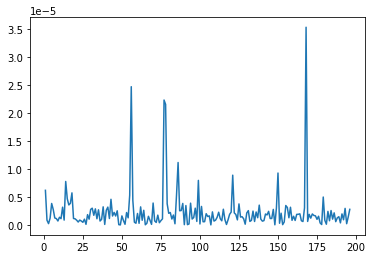

In [15]:
#YY = model.loc1.weight
X_all2.grad
YY = torch.mean(X_all2.grad,0)
YY
#max_x=tf.reduce_max(x.detach().numpy());
#max_x
XX = np.arange(0,YY.shape[0])+1
plt.plot(XX, abs(YY))

In [11]:
X_all2.grad.shape

torch.Size([10000, 196])

In [22]:
x =  torch.mean(X_all2.grad,0)
max_x=tf.reduce_min(abs(x).detach().numpy());
max_x

<tf.Tensor: shape=(), dtype=float32, numpy=3.045774e-09>

In [23]:
import os
import csv
XX = torch.mean(X_all2.grad,0)
filename_metric = 'Grad2' + '.csv'
with open(os.path.join('E:/', filename_metric), "a+") as fp:
    wr = csv.writer(fp, dialect='excel'); 
    wr.writerow(abs(XX));

In [ ]:
f = nn.Flatten()
x = torch.randn((2, 2, 3))
print('Before flatten shape : ', x.shape)
print('After flatten shape : ', f(x).shape)

In [ ]:
input_tensor = torch.Tensor(np.ones(shape=[10, 2, 3, 4]))
print(input_tensor.shape)
flatten1 = torch.nn.Sequential(torch.nn.Flatten(start_dim=1))

output1 = flatten1(input_tensor)
print(output1.shape)

In [18]:
Beta

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.42280453],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.31364927],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0